In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
import acquire
import prepare
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use("ggplot")
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from prophet import Prophet


In [160]:
df = prepare.prep_store_data(df=acquire.join_data())
df.head(1)


Using cached data for items
Using cached data for stores
Using cached data sales
Using cached data for prepped store


,item,quantity_sold,sale_id,store,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,month,day_of_week,sales_total
2013-01-01 00:00:00+00:00,1,13.0,1,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,1,1,10.92


In [161]:
df.shape

(913000, 18)

In [162]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [163]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [164]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

Using saas.csv or log data from API usage or store_item_sales



In [165]:
# resample daily and sum quantity sold and sales total
df = df.resample("D")[['quantity_sold', 'sales_total']].sum()
df.shape


(1826, 2)

In [166]:
#furter prep data to remove leap days
df = df[df.index!='2016-02-29']
df.shape


(1825, 2)

1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.


In [167]:
#split data into train validation and test
# I will resample by weel so Ill adjust to start and end on full weeks
n_weeks = df.shape[0]/7
validate_end_index = int(n_weeks*0.8*7+1)
train_end_index = int(n_weeks*0.5*7+4)

# split into train, validation, test
train = df[: train_end_index]
validate = df[train_end_index : validate_end_index]
test = df[validate_end_index : ]

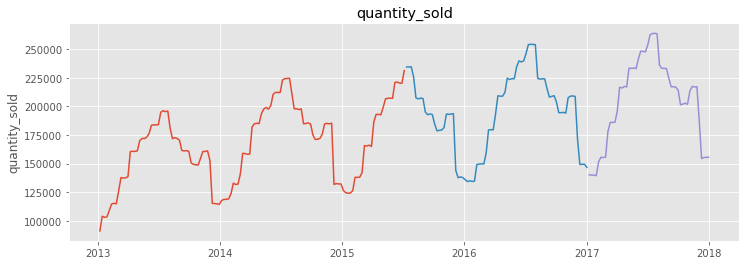

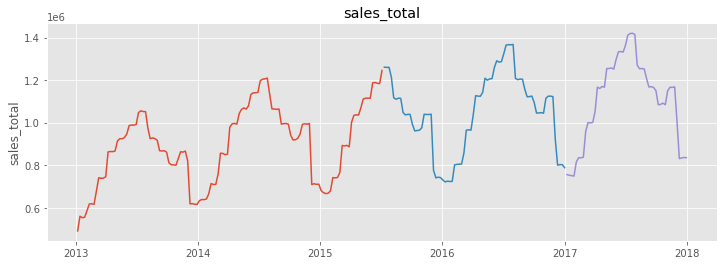

In [168]:
# resample by week
train = train.resample("W")[['quantity_sold', 'sales_total']].sum()
validate = validate.resample("W")[['quantity_sold', 'sales_total']].sum()
test = test.resample("W")[['quantity_sold', 'sales_total']].sum()

for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()


2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:


    Simple Average


In [169]:
items = round(train['quantity_sold'].mean(), 2)
dollars = round(train['sales_total'].mean(), 2)


yhat_df = pd.DataFrame({'quantity_sold': [items],
                            'sales_total': [dollars],
                           }, index = validate.index)

yhat_df.head(3)

,quantity_sold,sales_total
2015-07-12 00:00:00+00:00,166235.95,893763.65
2015-07-19 00:00:00+00:00,166235.95,893763.65
2015-07-26 00:00:00+00:00,166235.95,893763.65


quantity_sold -- RMSE: 44550


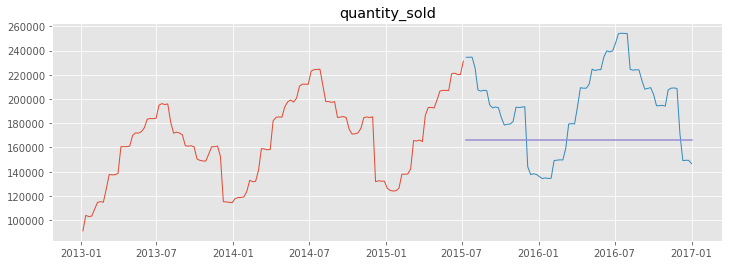

sales_total -- RMSE: 239397


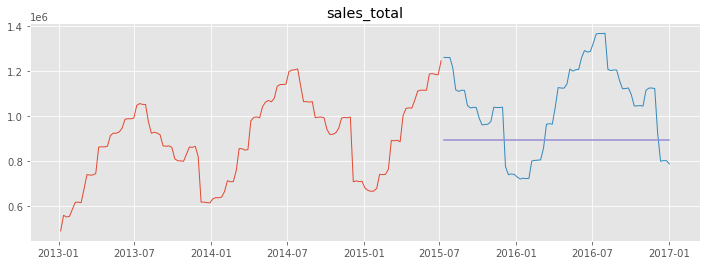

In [170]:
for col in train.columns:
    plot_and_eval(col)

In [171]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,simple_average,quantity_sold,44550.0
1,simple_average,sales_total,239397.0


    Moving Average


In [172]:
# compute a 2 week rolling average, 
# use the most recent/last 2 week period value to predict forward. 

period = 2

items = round(train['quantity_sold'].rolling(period).mean().iloc[-1], 2)
dollars = round(train['sales_total'].rolling(period).mean().iloc[-1], 2)

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'quantity_sold': [items],
                            'sales_total': [dollars],
                           }, index = validate.index)
yhat_df.head(2)

,quantity_sold,sales_total
2015-07-12 00:00:00+00:00,225743.0,1214315.92
2015-07-19 00:00:00+00:00,225743.0,1214315.92


quantity_sold -- RMSE: 46008


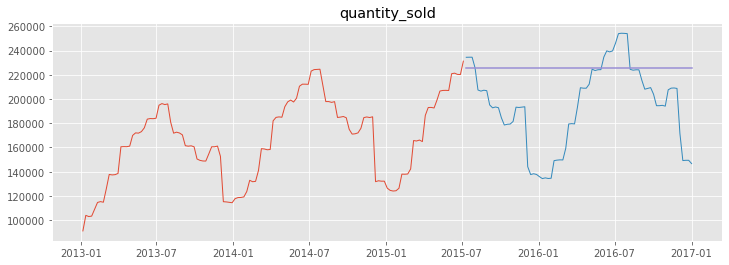

sales_total -- RMSE: 247801


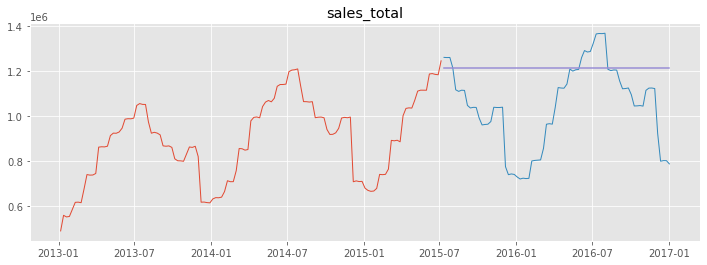

In [173]:
for col in train.columns:
    plot_and_eval(col)

In [174]:
for col in train.columns:
    eval_df = append_eval_df(model_type='2w moving average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,simple_average,quantity_sold,44550.0
1,simple_average,sales_total,239397.0
2,2w moving average,quantity_sold,46008.0
3,2w moving average,sales_total,247801.0


    Holt's Linear Trend Model


In [175]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .5, 
                      smoothing_slope = .5, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

quantity_sold -- RMSE: 186323


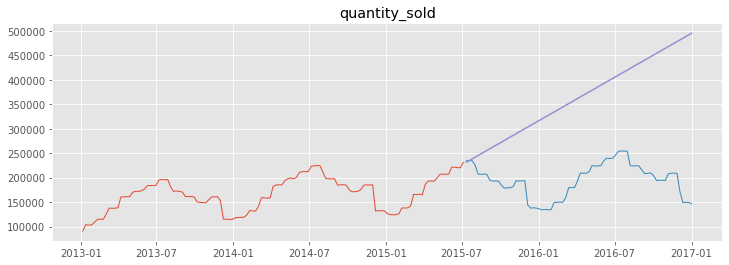

sales_total -- RMSE: 1017720


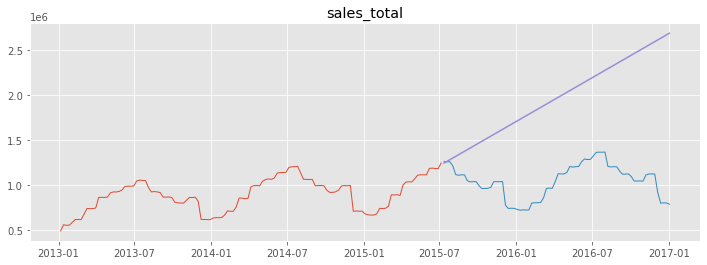

In [176]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

    Based on previous year/month/etc., this is up to you.


In [177]:
# predect based of of last year plus average difference
yhat_df= train['2014-07-12':'2015-07-12 '] +train.diff(52).mean()
pd.concat([yhat_df.head(1), validate.head(1)])


,quantity_sold,sales_total
2014-07-13 00:00:00+00:00,241799.772152,1.298314e+06
2015-07-12 00:00:00+00:00,234450.000000,1.260464e+06


In [178]:
#change validate to fit size of yhat_df
validate = validate[:'2016-07-3']

In [179]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

52

quantity_sold -- RMSE: 8045


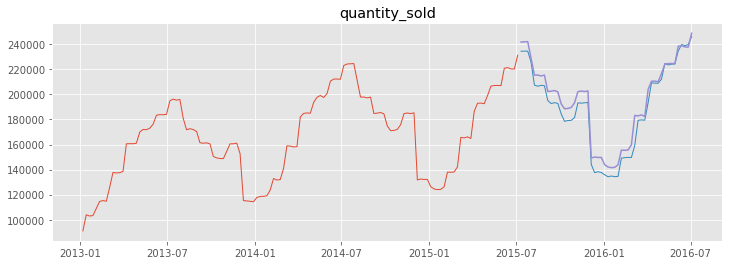

sales_total -- RMSE: 43171


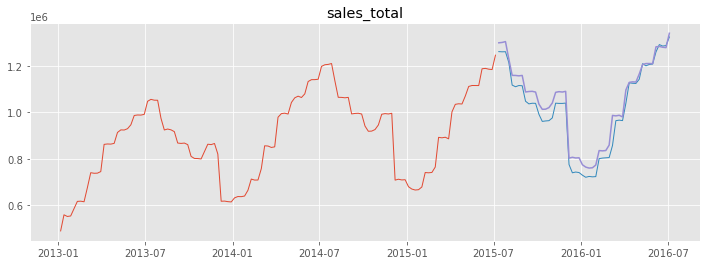

In [180]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)


In [181]:
eval_df

,model_type,target_var,rmse
0,simple_average,quantity_sold,44550.0
1,simple_average,sales_total,239397.0
2,2w moving average,quantity_sold,46008.0
3,2w moving average,sales_total,247801.0
4,Holts,quantity_sold,186323.0
5,Holts,sales_total,1017720.0
6,previous year,quantity_sold,8045.0
7,previous year,sales_total,43171.0


### Prophet

In [182]:
#restructure data to fit prophet
df = prepare.prep_store_data(df=acquire.join_data())
df = df.resample("D")[['quantity_sold']].sum()
df = df[df.index != '2016-02-29']
df.rename(columns = {'quantity_sold': 'y'}, inplace = True)
df['ds'] = df.index.date
df.reset_index(drop=True).head()
train = df[:'2015']
validate = df['2016']
test = df['2017']


Using cached data for items
Using cached data for stores
Using cached data sales
Using cached data for prepped store


In [183]:

model = Prophet()
model.fit(train)
future = model.make_future_dataframe(periods = 365)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -32.8174
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3438.81    0.00868306       510.001           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       3441.45    5.7108e-05        98.424   1.948e-07       0.001      237  LS failed, Hessian reset 
     199       3442.32    0.00349098       183.837           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       3443.72   0.000110814       214.429   1.004e-06       0.001      352  LS failed, Hessian reset 
     299       3444.68    0.00155239       71.9785        0.66        0.66      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306        3444.9   6.67296e-05       178.118   5.177e-07       0.001      506  LS failed, Hessian rese

In [184]:
yhat = model.predict(future)
yhat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



,ds,yhat,yhat_lower,yhat_upper
1455,2016-12-26,16089.328275,14069.543497,18314.736510
1456,2016-12-27,19299.207291,17326.837921,21441.357173
1457,2016-12-28,19349.229262,17303.458594,21491.807913
1458,2016-12-29,20944.072305,18965.914687,23123.490087
1459,2016-12-30,22566.122263,20707.779726,24822.508643


In [185]:
yhat_df = round(yhat[['yhat','ds']].tail(365),2)
yhat_df.rename(columns = {'yhat': 'quantity_sold'}, inplace = True)
yhat_df.set_index('ds', inplace = True)
yhat_df.head()

,quantity_sold
ds,
2016-01-01,21191.71
2016-01-02,22815.38
2016-01-03,24435.31
2016-01-04,14722.62
2016-01-05,17878.97


In [186]:
def plot_and_eval_prophet(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train['y'])
    plt.plot(validate['y'])
    plt.plot(yhat_df[target_var])
    plt.title('y')
    rmse = round(sqrt(mean_squared_error(validate["y"], yhat_df[target_var])), 0)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

quantity_sold -- RMSE: 4399


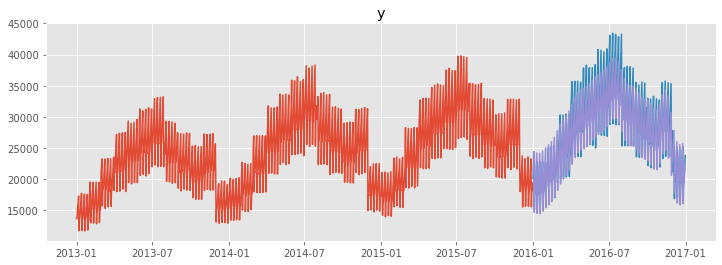

In [187]:
plot_and_eval_prophet('quantity_sold')

In [188]:
def run_prophet(target_var, period):
    df = prepare.prep_store_data(df=acquire.join_data())
    df = df.resample("D")[[target_var]].sum()
    df = df[df.index != '2016-02-29']
    df.rename(columns = {target_var: 'y'}, inplace = True)
    df['ds'] = df.index.date
    df.reset_index(drop=True).head()
    train = df[:'2015']
    validate = df['2016']
    #test = df['2017']
    model = Prophet()
    model.fit(train)
    future = model.make_future_dataframe(periods = period)
    yhat = model.predict(future)
    yhat_df = round(yhat[['yhat','ds']].tail(period),2)
    yhat_df.rename(columns = {'yhat': target_var}, inplace = True)
    yhat_df.set_index('ds', inplace = True)
    yhat_df.head()
    return train, validate, yhat_df

Using cached data for items
Using cached data for stores
Using cached data sales
Using cached data for prepped store


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -32.8174
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3438.81    0.00868306       510.001           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       3441.45    5.7108e-05        98.424   1.948e-07       0.001      237  LS failed, Hessian reset 
     199       3442.32    0.00349098       183.837           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       3443.72   0.000110814       214.429   1.004e-06       0.001      352  LS failed, Hessian reset 
     299       3444.68    0.00155239       71.9785        0.66        0.66      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306        3444.9   6.67296e-05       178.118   5.177e-07       0.001      506  LS failed, Hessian rese

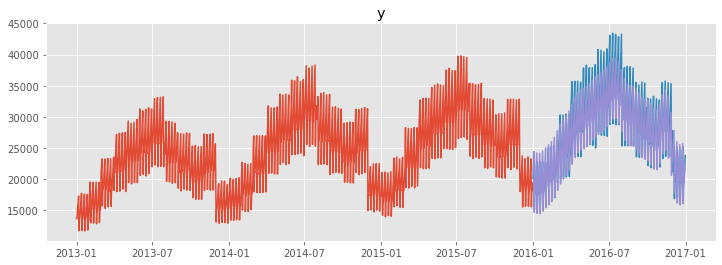

In [189]:
train, validate, yhat_df = run_prophet('quantity_sold', 365)
plot_and_eval_prophet('quantity_sold')

Using cached data for items
Using cached data for stores
Using cached data sales
Using cached data for prepped store


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -32.7939
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3431.67    0.00941877       245.405           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3438.46     0.0010653       185.483      0.2078           1      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3441.33   0.000409195       110.308           1           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3441.74   2.88936e-05       54.6185      0.7988      0.7988      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3442.25   0.000249761       68.2729           1           1      653   
    Iter      log prob        ||dx||      ||grad||       alpha  

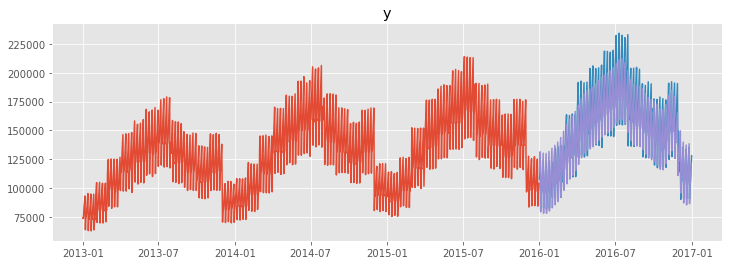

In [190]:
train, validate, yhat_df = run_prophet('sales_total', 365)
plot_and_eval_prophet('sales_total')

The above information is based on the Prophet model by day and could be changed to week to match above models. 
This model out perfoms instruction examples which we based on daily aggragation.

Optional: Using store item demand



1. Predict 2018 total monthly sales for a single store and/or item by creating a model.


In [191]:
df.head()

,y,ds
2013-01-01 00:00:00+00:00,13696.0,2013-01-01
2013-01-02 00:00:00+00:00,13678.0,2013-01-02
2013-01-03 00:00:00+00:00,14488.0,2013-01-03
2013-01-04 00:00:00+00:00,15677.0,2013-01-04
2013-01-05 00:00:00+00:00,16237.0,2013-01-05


In [192]:
def run_prophet2(df, store_num, target_var,period):
    #df=prepare.prep_store_data(df=acquire.join_data())
    df2 = df.copy()
    df2 =df2[df2['store']==store_num]
    df2 = df2.resample("D")[[target_var]].sum()
    df2 = df2[df2.index != '2016-02-29']
    df2.rename(columns = {target_var: 'y'}, inplace = True)
    df2['ds'] = df2.index.date
    df2.reset_index(drop=True).head()
    train = df2
    model = Prophet()
    model.fit(train)
    future = model.make_future_dataframe(periods = period)
    yhat = model.predict(future)
    yhat_df = round(yhat[['yhat','ds']].tail(period),2)
    yhat_df.rename(columns = {'yhat': target_var}, inplace = True)
    yhat_df.set_index('ds', inplace = True)
    yhat_df.head()
    return train, yhat_df


In [193]:
def plot_prophet2(df, target_var, period=365):
    for i in range(1,df.store.nunique()+1):
        print(i)
        store_num=i
        train, yhat_df = run_prophet2(df, store_num, target_var, period)
        plt.figure(figsize=(12,4))
        plt.plot(train['y'])
        plt.plot(yhat_df[target_var])
        plt.title(f"store: {store_num} {target_var}")
    plt.show()

In [194]:
df = prepare.prep_store_data(df=acquire.join_data())

Using cached data for items
Using cached data for stores
Using cached data sales
Using cached data for prepped store


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1
Initial log joint probability = -29.6063
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5569.82     0.0110871       320.466           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5586.58     0.0255966       270.667           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5600.32    0.00432113       523.759           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5603.57   0.000460671       96.3092           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5605.12   0.000209439       98.1427      0.3026           1      589   
    Iter      log prob        ||dx||      ||grad||       alpha

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2
Initial log joint probability = -35.2478
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5553.87   0.000380694       224.568      0.8406      0.8406      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5587.98    0.00428419       587.654           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       5590.21   6.24724e-05       125.498   1.291e-07       0.001      307  LS failed, Hessian reset 
     289       5595.02    0.00013619       194.655   1.376e-06       0.001      438  LS failed, Hessian reset 
     299       5595.54   0.000467222       215.464      0.2349           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5597.67   0.000338185       78.3992           1           1      583   
    Iter      log p

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3
Initial log joint probability = -31.3132
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5535.99    0.00478551       271.518      0.6521      0.6521      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5552.12    0.00842241       372.407           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5559.48   0.000650249         254.1           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     362       5560.38   8.50959e-05       304.426   2.986e-07       0.001      477  LS failed, Hessian reset 
     399       5561.04   7.88106e-05       70.3824      0.3783           1      533   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     433       5561.42     2.811e-05  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


4
Initial log joint probability = -30.3738
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5573.59    0.00228688       1119.74      0.3566      0.3566      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5594.92    0.00204279       313.504           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5603.84   0.000470169       174.975      0.3256           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5606.56    0.00397075       150.498      0.9282      0.9282      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     419       5606.94   3.03785e-05       111.451   4.335e-07       0.001      528  LS failed, Hessian reset 
     499       5607.78    0.00238385  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5
Initial log joint probability = -36.7753
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5446.99     0.0130561       1368.33           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5472.18    0.00117985       325.987      0.8488      0.8488      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       5475.76   3.75499e-05        115.42   1.853e-07       0.001      286  LS failed, Hessian reset 
     224        5477.1   3.90692e-05       105.219   1.751e-07       0.001      346  LS failed, Hessian reset 
     299       5479.77    0.00024869       165.619      0.6557      0.6557      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       5479.89   0.000161674       167.219   2.158e-06       0.001      497  LS failed, Hessian re

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6
Initial log joint probability = -31.1026
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5497.85     0.0142859       569.361           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5520.68    0.00418555       635.613           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5526.34   0.000375594        92.014           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     384        5528.2   3.34195e-05       115.128   2.495e-07       0.001      510  LS failed, Hessian reset 
     399       5528.44   0.000102287       137.356     0.03404      0.2892      527   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     478       5529.54   0.000197168  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7
Initial log joint probability = -32.5217
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5479.27    0.00147215       191.285           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5498.46    0.00367207       318.268           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       5501.05   0.000155559       405.666   5.366e-07       0.001      320  LS failed, Hessian reset 
     288       5503.93   8.00459e-05       218.946   6.072e-07       0.001      431  LS failed, Hessian reset 
     299       5504.85    0.00113193        111.04           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5506.35   0.000360447       241.582      0.6036      0.6036      573   
    Iter      log p

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


8
Initial log joint probability = -36.2424
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5551.04    0.00396995        1555.8      0.4222           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5581.55    0.00117306       706.039     0.07948      0.8516      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5587.88   0.000135806       106.512      0.8749      0.8749      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5593.24   0.000328673       81.3843           1           1      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5594.34   0.000750989       82.5199           1           1      604   
    Iter      log prob        ||dx||      ||grad||       alpha

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


9
Initial log joint probability = -34.832
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5560.81    0.00994612       930.566           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5588.3    0.00166761       257.301      0.3188      0.9481      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5594.28    0.00296848        437.95      0.3541      0.3541      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     387       5597.62   2.46962e-05       93.1173   1.844e-07       0.001      512  LS failed, Hessian reset 
     399       5597.69   0.000244713       136.253      0.2647           1      528   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5601.62    0.00123934   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -35.72
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5533.76     0.0049431       302.163      0.7375      0.7375      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5562.74     0.0217671        184.71           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5567.42   0.000682599        80.771           1           1      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5568.84    0.00130108        235.02      0.2343           1      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5570.83   0.000200913       76.4176      0.3755           1      641   
    Iter      log prob        ||dx||      ||grad||       alpha    

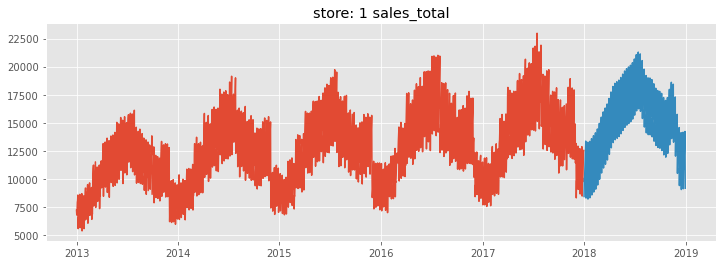

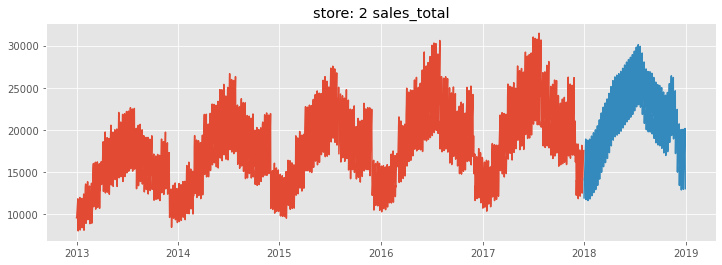

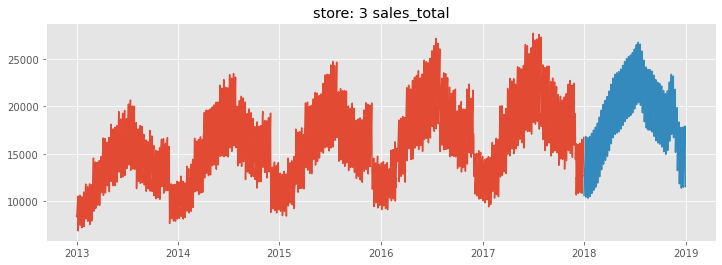

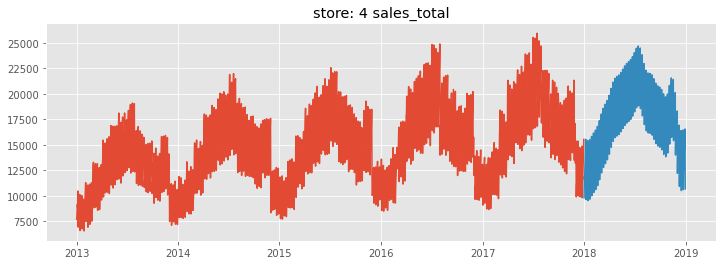

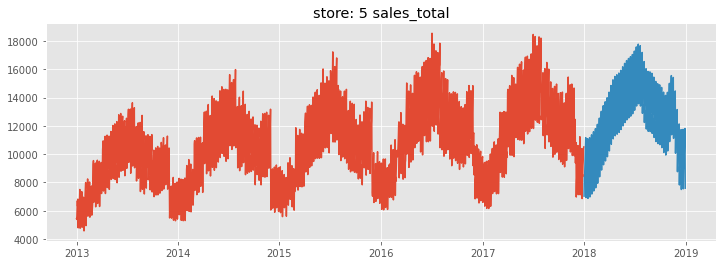

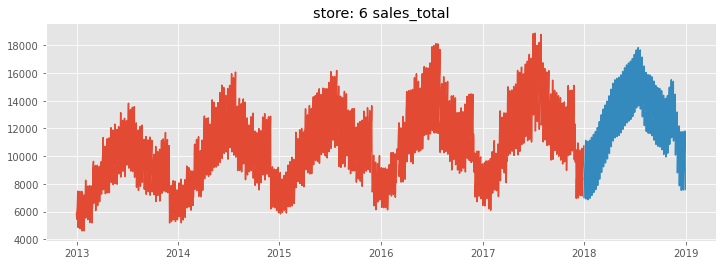

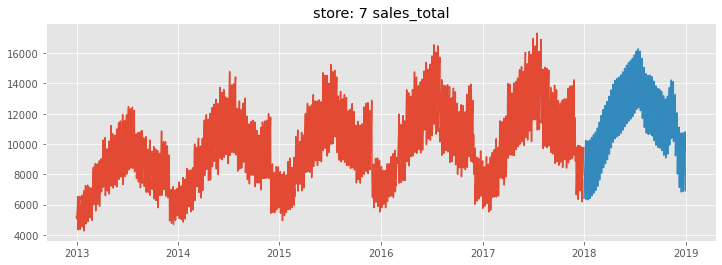

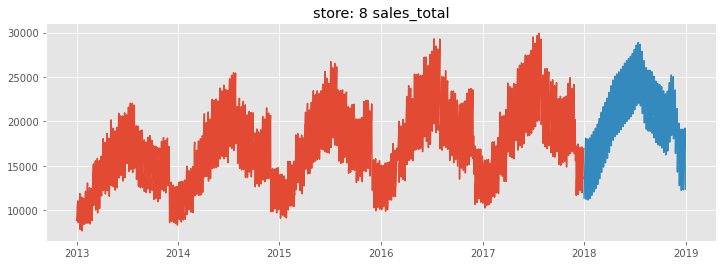

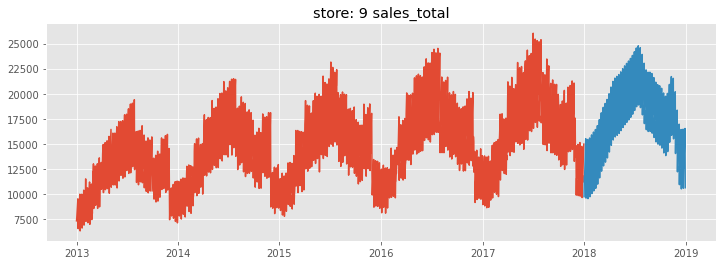

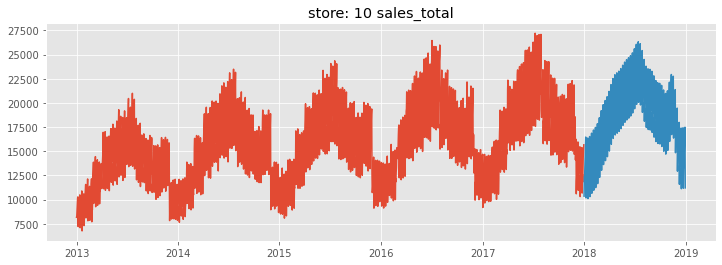

In [195]:
plot_prophet2(df,'sales_total', 365)

2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).

3. Plot the 2018 monthly sales predictions.

In [196]:
def run_prophet3(df, store_num, target_var,period):
    results = pd.DataFrame()
    #df=prepare.prep_store_data(df=acquire.join_data())
    df2 = df.copy()
    df2 =df2[df2['store']==store_num]
    df2 = df2.resample("D")[[target_var]].sum()
    df2 = df2[df2.index != '2016-02-29']
    df2.rename(columns = {target_var: 'y'}, inplace = True)
    df2['ds'] = df2.index.date
    df2.reset_index(drop=True).head()
    train = df2
    model = Prophet()
    model.fit(train)
    future = model.make_future_dataframe(periods = period)
    yhat = model.predict(future)
    yhat['store_num'] = store_num
    results = results.append(yhat[['ds','store_num','yhat','yhat_lower', 'yhat_upper']].tail(period), ignore_index=True)
    results.rename(columns = {'ds': 'month'}, inplace = True)
    #results.month = pd.to_datetime(results.month.month, format='%m')
    return results

In [197]:
results = run_prophet3(df, 1, 'sales_total', 365)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -29.6063
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5569.82     0.0110871       320.466           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5586.58     0.0255966       270.667           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5600.32    0.00432113       523.759           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5603.57   0.000460671       96.3092           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5605.12   0.000209439       98.1427      0.3026           1      589   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [198]:
results.head()

,month,store_num,yhat,yhat_lower,yhat_upper
0,2018-01-01,1,8432.684186,7669.591233,9213.018508
1,2018-01-02,1,10069.384247,9256.834589,10892.681424
2,2018-01-03,1,10119.223807,9292.024906,10930.972089
3,2018-01-04,1,10893.005854,10059.823574,11740.299134
4,2018-01-05,1,11697.504765,10910.959704,12516.510488


In [199]:
#change ds to month
#results.ds = pd.to_datetime(results.month,format='%Y')
#results.month = results.month.strftime('%Y-%m')
results.head(10)

,month,store_num,yhat,yhat_lower,yhat_upper
0,2018-01-01,1,8432.684186,7669.591233,9213.018508
1,2018-01-02,1,10069.384247,9256.834589,10892.681424
2,2018-01-03,1,10119.223807,9292.024906,10930.972089
3,2018-01-04,1,10893.005854,10059.823574,11740.299134
4,2018-01-05,1,11697.504765,10910.959704,12516.510488
5,2018-01-06,1,12553.988739,11760.476473,13325.788533
6,2018-01-07,1,13369.392463,12565.266573,14192.354794
7,2018-01-08,1,8296.664709,7432.152777,9110.957212
8,2018-01-09,1,9925.175281,9075.412384,10681.855841
9,2018-01-10,1,9971.840054,9124.608971,10770.048209


In [200]:
results.set_index('month', inplace = True)

In [201]:
results = results.resample('M')[['store_num','yhat','yhat_lower', 'yhat_upper']].sum()
#change store_num value to 1
results.store_num = 1
#change index to show year and month
results.index = results.index.strftime('%Y-%m')



In [202]:
results

,store_num,yhat,yhat_lower,yhat_upper
month,,,,
2018-01,1,336064.548561,310839.395111,360824.021545
2018-02,1,333936.061175,311594.464390,356584.080729
2018-03,1,429599.109581,404469.331742,454643.502153
2018-04,1,471065.911990,446540.098835,495557.443540
2018-05,1,517733.397500,491988.567458,543543.758223
2018-06,1,533672.663389,507874.583626,559283.142146
2018-07,1,574746.432297,547730.518260,602527.651189
2018-08,1,521864.424197,493131.040484,550744.766067
2018-09,1,477877.410207,448846.252353,507170.959605
